In [2]:
import sqlite3
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from dateutil import parser
from matplotlib import style
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
style.use('fivethirtyeight')

# establish connection to database
conn = sqlite3.connect( 'brazilian_ecommerce.db')

In [ ]:
# RFM Analysis
query = """
WITH customer_calculations AS (
    SELECT DISTINCT c.customer_unique_id,
        MAX(o.order_purchase_timestamp) as last_order_date,
        COUNT(o.order_id) as order_count,
        AVG(op.payment_value) as avg_spent
    FROM orders o 
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
    INNER JOIN order_payments op 
    ON o.order_id = op.order_id
    GROUP BY 1
), quantiles AS (
    SELECT customer_unique_id,
        NTILE(4) OVER (ORDER BY last_order_date) as rfm_recency,
        NTILE(4) OVER (ORDER BY order_count) as rfm_frequency,
        NTILE(4) OVER (ORDER BY avg_spent) as rfm_monetary
    FROM customer_calculations
), combined_rfm AS (
SELECT customer_unique_id, 
    rfm_recency * 100 + rfm_frequency * 10 + rfm_monetary as rfm_combined
FROM quantiles
)
    SELECT COUNT(DISTINCT customer_unique_id), 
        CASE 
            WHEN rfm_combined > 400 THEN 'Active' 
            WHEN rfm_combined > 300 AND rfm_combined < 400 THEN 'Slipping Away'
            WHEN rfm_combined > 200 AND rfm_combined < 300 THEN 'At Risk'
            WHEN rfm_combined > 100 AND rfm_combined < 200 THEN 'Lost'
            ELSE NULL
        END as customer_status
    FROM combined_rfm
    GROUP BY 2
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [7]:
# Which products are purchased most frequently?
query = """
SELECT product_category_name_english as product_category,
    COUNT(DISTINCT o.order_id) as total_orders,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
    COUNT(DISTINCT c.customer_unique_id) as total_buyers,
    CAST(1.0 * SUM(op.payment_value) / NULLIF(COUNT(DISTINCT o.customer_id),0) AS int) as avg_spend_per_cust
FROM orders o 
INNER JOIN order_items oi
ON o.order_id = oi.order_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
INNER JOIN customers c
ON o.customer_id = c.customer_id
INNER JOIN products p
ON oi.product_id = p.product_id
INNER JOIN product_translations pt 
ON p.product_category_name = pt.product_category_name
GROUP BY 1
ORDER BY 3 DESC
LIMIT 10
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,product_category,total_orders,total_spend_dollars,total_buyers,avg_spend_per_cust
0,bed_bath_table,9417,1712553,9145,181
1,health_beauty,8835,1657373,8677,187
2,computers_accessories,6689,1585330,6557,237
3,furniture_decor,6449,1430176,6317,221
4,watches_gifts,5624,1429216,5547,254
5,sports_leisure,7720,1392127,7515,180
6,housewares,5884,1094758,5821,186
7,auto,3897,852294,3852,218
8,garden_tools,3518,838280,3489,238
9,cool_stuff,3632,779698,3615,214


In [11]:
# Total buyers

query = """
SELECT COUNT(DISTINCT customer_unique_id) as total_buyers
FROM customers 
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,total_buyers
0,96096


In [14]:
# Total transactions

query = """
SELECT COUNT(DISTINCT order_id) as total_transactions
FROM orders 
;
"""


df = pd.read_sql(query, conn)
df.head(100)

,total_transactions
0,99441


In [16]:
# Avg Spend Per Buyer

query = """
SELECT CAST(1.0 * SUM(op.payment_value) / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) AS int) as avg_spend_per_cust
FROM orders o 
INNER JOIN order_payments op 
ON o.order_id = op.order_id
INNER JOIN customers c 
ON o.customer_id = c.customer_id
"""


df = pd.read_sql(query, conn)
df.head(100)

,avg_spend_per_cust
0,166


In [4]:
# Avg Orders Per Buyer
query = """
WITH orders_per_cust AS (
    SELECT c.customer_unique_id,
        COUNT(DISTINCT o.order_id) as total_orders
    FROM customers c
    INNER JOIN orders o
    ON c.customer_id = o.customer_id
    GROUP BY 1
)
SELECT AVG(total_orders) avg_order_per_cust
FROM orders_per_cust
"""


df = pd.read_sql(query, conn)
df.head(100)

,avg_order_per_cust
0,1.034809


In [ ]:
# New Buyers

In [ ]:
# 14-Day Repurchase Rate

In [15]:
# 30-Day LTV
query = """
WITH purchase_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), spend_per_customer_30d AS (
    SELECT por.customer_unique_id,
        CAST(SUM(op.payment_value) AS int) as spend_first_30d
    FROM purchase_order_rank por
    LEFT JOIN customers c
    ON por.customer_unique_id = c.customer_unique_id
    LEFT JOIN orders o
    ON por.customer_id = o.customer_id
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    AND o.order_purchase_timestamp - por.order_purchase_timestamp <= 30
    WHERE por.order_rank = 1
    GROUP BY 1
)
SELECT CAST(AVG(spend_first_30d) AS int) as avg_ltv
FROM spend_per_customer_30d
LIMIT 20
;
"""

df = pd.read_sql(query, conn)
df.head(100)


,avg_ltv
0,166


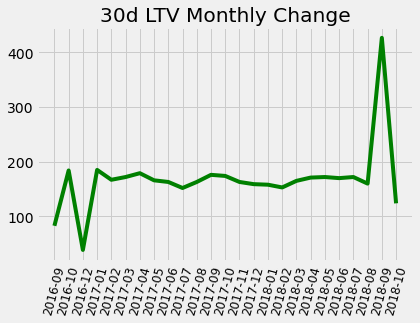

In [17]:
# Plot
c = conn.cursor()
fig, ax = plt.subplots()

c.execute("""
WITH purchase_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), spend_per_customer_30d AS (
    SELECT por.customer_unique_id,
        strftime('%Y-%m', por.order_purchase_timestamp) as first_purchase_month,
        CAST(SUM(op.payment_value) AS int) as spend_first_30d
    FROM purchase_order_rank por
    LEFT JOIN customers c
    ON por.customer_unique_id = c.customer_unique_id
    LEFT JOIN orders o
    ON por.customer_id = o.customer_id
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    AND o.order_purchase_timestamp - por.order_purchase_timestamp <= 30
    WHERE por.order_rank = 1
    GROUP BY 1,2
)
SELECT first_purchase_month,
    CAST(AVG(spend_first_30d) AS int) as avg_ltv
FROM spend_per_customer_30d
GROUP BY 1
ORDER BY 1 
;
""")
data = c.fetchall()

first_purchase_month = []
avg_ltv = []
width = 0.4

for row in data:
    first_purchase_month.append(row[0])
    avg_ltv.append(row[1])
    
    ax.set(title = "30d LTV Monthly Change")
    
plt.plot(first_purchase_month, avg_ltv, "-g", label = "Avg 30d LTV")
plt.xticks(rotation=75, size=12)
plt.show()

In [20]:
# Star Rating
query = """
SELECT AVG(review_score) as avg_star_rating
FROM order_reviews 
;
"""

df = pd.read_sql(query, conn)
df.head(1)

,avg_star_rating
0,4.07089


In [26]:
# Review Rate
query = """
SELECT 1.0 * COUNT(DISTINCT c.customer_unique_id) / COUNT(DISTINCT r.review_id) as review_rate
FROM customers c
LEFT JOIN orders o
ON c.customer_id = o.customer_id
LEFT JOIN order_reviews r 
ON o.order_id = r.order_id
"""


df = pd.read_sql(query, conn)
df.head(100)

,review_rate
0,0.968973


In [ ]:
# Frequently purchased products change over time
query = """
SELECT product_category_name_english as product_category,
    COUNT(DISTINCT o.order_id) as total_orders,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
    COUNT(DISTINCT c.customer_unique_id) as total_buyers,
    CAST(1.0 * SUM(op.payment_value) / NULLIF(COUNT(DISTINCT o.customer_id),0) AS int) as avg_spend_per_cust
FROM orders o 
INNER JOIN order_items oi
ON o.order_id = oi.order_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
INNER JOIN customers c
ON o.customer_id = c.customer_id
INNER JOIN products p
ON oi.product_id = p.product_id
INNER JOIN product_translations pt 
ON p.product_category_name = pt.product_category_name
GROUP BY 1
HAVING total_spend_dollars > 150000
ORDER BY 3 desc


;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [ ]:
# Plotted Graph
query = conn.execute("""
SELECT product_category_name_english as product_category,
    strftime('%m', o.order_purchase_timestamp) as order_month,
    COUNT(DISTINCT o.order_id) as total_orders,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
    COUNT(DISTINCT c.customer_unique_id) as total_buyers,
    CAST(1.0 * SUM(op.payment_value) / NULLIF(COUNT(DISTINCT o.customer_id),0) AS int) as avg_spend_per_cust
FROM orders o 
INNER JOIN order_items oi
ON o.order_id = oi.order_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
INNER JOIN customers c
ON o.customer_id = c.customer_id
INNER JOIN products p
ON oi.product_id = p.product_id
INNER JOIN product_translations pt 
ON p.product_category_name = pt.product_category_name
GROUP BY 1,2
HAVING total_spend_dollars > 150000
ORDER BY 3 desc
;
""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

ax=results.pivot_table(index='order_month',columns='product_category',values='total_spend_dollars').plot(kind='bar',stacked=True,figsize=(15,15),fontsize=25)
ax.legend(fontsize=25)

#set ylim
plt.ylim(-1, 1000000)
plt.xlim(-1,11)
#grid on
plt.grid(2)
# set y=0
ax.axhline(0, color='black', lw=1)
#change size of legend
ax.legend(fontsize=25,loc=(1.0,0.4), title='Total Spend')
#hiding upper and right axis layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#changing the thickness
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#setlabels
ax.set_title('Total Spend per Product Category by Month',fontsize=30,color='black')
ax.set_xlabel('Order Month',fontsize=20,color='black')
ax.set_ylabel('Total Spend',fontsize=20,color='black')
#rotation
plt.xticks(rotation=360)

In [ ]:
# How many total customers purchase items each month, and how much does each spend on avg?
query = """
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as order_month,
    COUNT(DISTINCT c.customer_unique_id) as total_customers,
    CAST(AVG(op.payment_value) AS int) as avg_spent_per_customer
FROM orders o 
INNER JOIN customers c
ON o.customer_id = c.customer_id
INNER JOIN order_payments op 
ON o.order_id = op.order_id
GROUP BY 1
ORDER BY 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [6]:
# Total spend per month
query = """
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as order_month,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars
FROM orders o 
INNER JOIN order_payments op 
ON o.order_id = op.order_id
GROUP BY 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,order_month,total_spend_dollars
0,2016-09,252
1,2016-10,59090
2,2016-12,19
3,2017-01,138488
4,2017-02,291908
5,2017-03,449863
6,2017-04,417788
7,2017-05,592918
8,2017-06,511276
9,2017-07,592382


In [7]:
# What percent of spend each month is coming from new vs existing buyers?
query = """
WITH order_details AS (
    SELECT o.*,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), total_spend_per_month AS (
    SELECT o.order_rank,
        strftime('%Y-%m', o.order_purchase_timestamp) as order_month,
        CAST(SUM(op.payment_value) AS int) as total_spend_dollars
    FROM order_details o 
    INNER JOIN order_payments op 
    ON o.order_id = op.order_id
    GROUP BY 2
)
SELECT a.order_month,
    1.0 * b.total_spend_dollars / NULLIF(a.total_spend_dollars,0) as pcnt_spend_by_new_buyers
FROM total_spend_per_month a
LEFT JOIN total_spend_per_month b
ON a.order_month = b.order_month
AND  b.order_rank = 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,order_month,pcnt_spend_by_new_buyers
0,2016-09,1.0
1,2016-10,NaN
2,2016-12,1.0
3,2017-01,1.0
4,2017-02,1.0
5,2017-03,1.0
6,2017-04,1.0
7,2017-05,1.0
8,2017-06,1.0
9,2017-07,1.0


In [ ]:
# Plotted Graph
c = conn.cursor()
fig, ax = plt.subplots()

c.execute('''
SELECT strftime('%m', o.order_purchase_timestamp) as order_month,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars
FROM orders o 
INNER JOIN order_payments op 
ON o.order_id = op.order_id
GROUP BY 1''')
data = c.fetchall()

order_month = []
total_spend_dollars = []

for row in data:
    order_month.append(row[0])
    total_spend_dollars.append(row[1])
    
    ax.set(title = "Total Spend per Month",
       xlabel = "Month",
       ylabel = "Total Spend")

plt.plot(order_month,total_spend_dollars,'-')
plt.show()

In [ ]:
# total spent per customer and payment type used
query = """
    SELECT c.customer_unique_id,
        op.payment_type,
        SUM(op.payment_value) as total_spend_dollars
    FROM order_payments op
    INNER JOIN orders o 
    ON op.order_id = o.order_id
    LEFT JOIN customers c
    ON o.customer_id = c.customer_id
    GROUP BY 1,2
    ORDER BY 3 DESC
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [ ]:
# who are the most valuable customers?
# how much did they spend? 
# how many transactions?

query = """
    SELECT c.customer_unique_id,
        c.customer_city,
        c.customer_state,
        CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
        COUNT(DISTINCT op.order_id) as total_orders
    FROM order_payments op
    INNER JOIN orders o 
    ON op.order_id = o.order_id
    LEFT JOIN customers c
    ON o.customer_id = c.customer_id
    GROUP BY 1,2,3
    ORDER BY 4 DESC
    LIMIT 25
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [6]:
# What cities are most valuable?

query = """
SELECT c.customer_city,
    c.customer_state,
    CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
    COUNT(DISTINCT o.order_id) as total_orders,
    COUNT(DISTINCT c.customer_unique_id) as total_buyers,
    CAST(SUM(op.payment_value) / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) AS int) as avg_spend_per_buyer
FROM orders o
INNER JOIN order_payments op
ON o.order_id = op.order_id
INNER JOIN customers c 
ON o.customer_id = c.customer_id
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 25
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,customer_city,customer_state,total_spend_dollars,total_orders,total_buyers,avg_spend_per_buyer
0,sao paulo,SP,2203373,15540,14984,147
1,rio de janeiro,RJ,1161927,6882,6620,175
2,belo horizonte,MG,421765,2773,2672,157
3,brasilia,DF,354216,2131,2069,171
4,curitiba,PR,247392,1521,1465,168
5,porto alegre,RS,224731,1379,1326,169
6,salvador,BA,218071,1245,1209,180
7,campinas,SP,216248,1444,1398,154
8,guarulhos,SP,165121,1189,1153,143
9,niteroi,RJ,139996,849,811,172


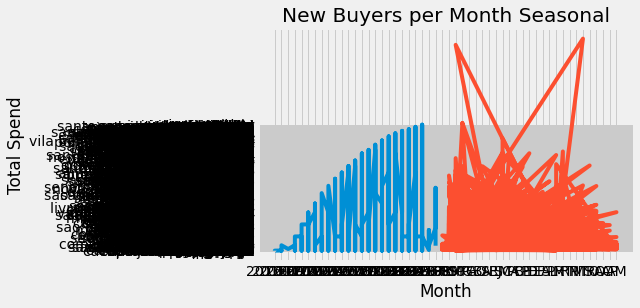

In [5]:
# What cities are most valuable?
c = conn.cursor()
fig, ax = plt.subplots()

c.execute('''
WITH valuable_geographies AS (
    SELECT o.*,
        c.customer_city,
        c.customer_state,
        CAST(SUM(op.payment_value) AS int) as total_spend_dollars,
        COUNT(DISTINCT o.order_id) as total_orders,
        COUNT(DISTINCT c.customer_unique_id) as total_buyers,
        CAST(SUM(op.payment_value) / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) AS int) as avg_spend_per_buyer
    FROM orders o
    INNER JOIN order_payments op
    ON o.order_id = op.order_id
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
    GROUP BY 2,3
    ORDER BY 4 DESC
)
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as order_month,
    vg.customer_city,
    vg.customer_state,
    vg.total_spend_dollars
FROM valuable_geographies vg
INNER JOIN orders o 
ON vg.order_id = o.order_id
GROUP BY 1,2,3
ORDER BY 1 
''')
data = c.fetchall()

order_month = []
customer_city = []
customer_state = []
total_spend_dollars = []

for row in data:
    order_month.append(row[0])
    customer_city.append(row[1])
    customer_state.append(row[2])
    total_spend_dollars.append(row[3])
    
    ax.set(title = "New Buyers per Month Seasonal",
       xlabel = "Month",
       ylabel = "Total Spend")

plt.plot(order_month,customer_city, customer_state, total_spend_dollars, '-')
plt.show()

In [ ]:
#  New buyers per month seasonal analysis
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%m', order_purchase_timestamp) as order_month,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1
ORDER BY 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [ ]:
# Plotted Graph
c = conn.cursor()
fig, ax = plt.subplots()

c.execute('''WITH order_rank AS (
SELECT o.*,
    c.customer_unique_id,
    RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
FROM orders o
INNER JOIN customers c 
ON o.customer_id = c.customer_id
)
SELECT strftime('%m', order_purchase_timestamp) as order_month,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1
ORDER BY 1''')
data = c.fetchall()

order_month = []
new_buyers = []

for row in data:
    order_month.append(row[0])
    new_buyers.append(row[1])
    
    ax.set(title = "New Buyers per Month Seasonal",
       xlabel = "Month",
       ylabel = "New Buyers")

plt.plot(order_month,new_buyers,'-')
plt.show()

# CASE 
#         WHEN strftime('%m', order_purchase_timestamp) = '01' THEN 'Jan'
#         WHEN strftime('%m', order_purchase_timestamp) = '02' THEN 'Feb'
#         WHEN strftime('%m', order_purchase_timestamp) = '03' THEN 'Mar'
#         WHEN strftime('%m', order_purchase_timestamp) = '04' THEN 'Apr'
#         WHEN strftime('%m', order_purchase_timestamp) = '05' THEN 'May'
#         WHEN strftime('%m', order_purchase_timestamp) = '06' THEN 'Jun'
#         WHEN strftime('%m', order_purchase_timestamp) = '07' THEN 'Jul'
#         WHEN strftime('%m', order_purchase_timestamp) = '08' THEN 'Aug'
#         WHEN strftime('%m', order_purchase_timestamp) = '09' THEN 'Sep'
#         WHEN strftime('%m', order_purchase_timestamp) = '010' THEN 'Oct'
#         WHEN strftime('%m', order_purchase_timestamp) = '010' THEN 'Nov'
#         ELSE 'Dec'
#     END as order_month

In [ ]:
#  New buyers per month
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%Y-%m', order_purchase_timestamp) as order_month,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1
ORDER BY 1 DESC
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [ ]:
# Plotted Graph
c = conn.cursor()
fig, ax = plt.subplots()

c.execute('''WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%Y-%m', order_purchase_timestamp) as order_month,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1
ORDER BY 1 DESC
;''')
data = c.fetchall()

order_month = []
new_buyers = []

for row in data:
    order_month.append(row[0])
    new_buyers.append(row[1])
    
    ax.set(title = "New Buyers per Month",
       xlabel = "Month",
       ylabel = "New Buyers")

plt.plot(order_month,new_buyers,'-')
plt.show()

In [ ]:
# New buyers per hour
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%H', order_purchase_timestamp)  as order_hour,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1
ORDER BY 1 
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [3]:
# Avgerage new buyers per month
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
), new_buyers AS(
    SELECT strftime('%Y-%m', order_purchase_timestamp)  as month,
        COUNT(DISTINCT customer_unique_id) as new_buyers
    FROM order_rank 
    WHERE customer_order_rank = 1
    GROUP BY 1
    ORDER BY 1
)
SELECT month,
    AVG(new_buyers) as avg_new_buyers_per_month
FROM new_buyers
GROUP BY 1
ORDER BY 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,month,avg_new_buyers_per_month
0,2016-09,4.0
1,2016-10,316.0
2,2016-12,1.0
3,2017-01,749.0
4,2017-02,1719.0
5,2017-03,2584.0
6,2017-04,2316.0
7,2017-05,3544.0
8,2017-06,3099.0
9,2017-07,3862.0


In [ ]:
# 24h Bar Chart
c = conn.cursor()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

c.execute("""
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%m', order_purchase_timestamp)  as order_month,
    strftime('%H', order_purchase_timestamp)  as order_hour,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1,2
ORDER BY 1,2 
;
""")
data = c.fetchall()

order_hour = []
new_buyers = []

for row in data:
    order_hour.append(row[0])
    new_buyers.append(row[1])
    
    ax.set(title = "Buyers by Hour of Day",
       xlabel = "Hour",
       ylabel = "New Buyers")

ax.bar(order_hour,new_buyers)
plt.xticks(rotation=45)
plt.show()



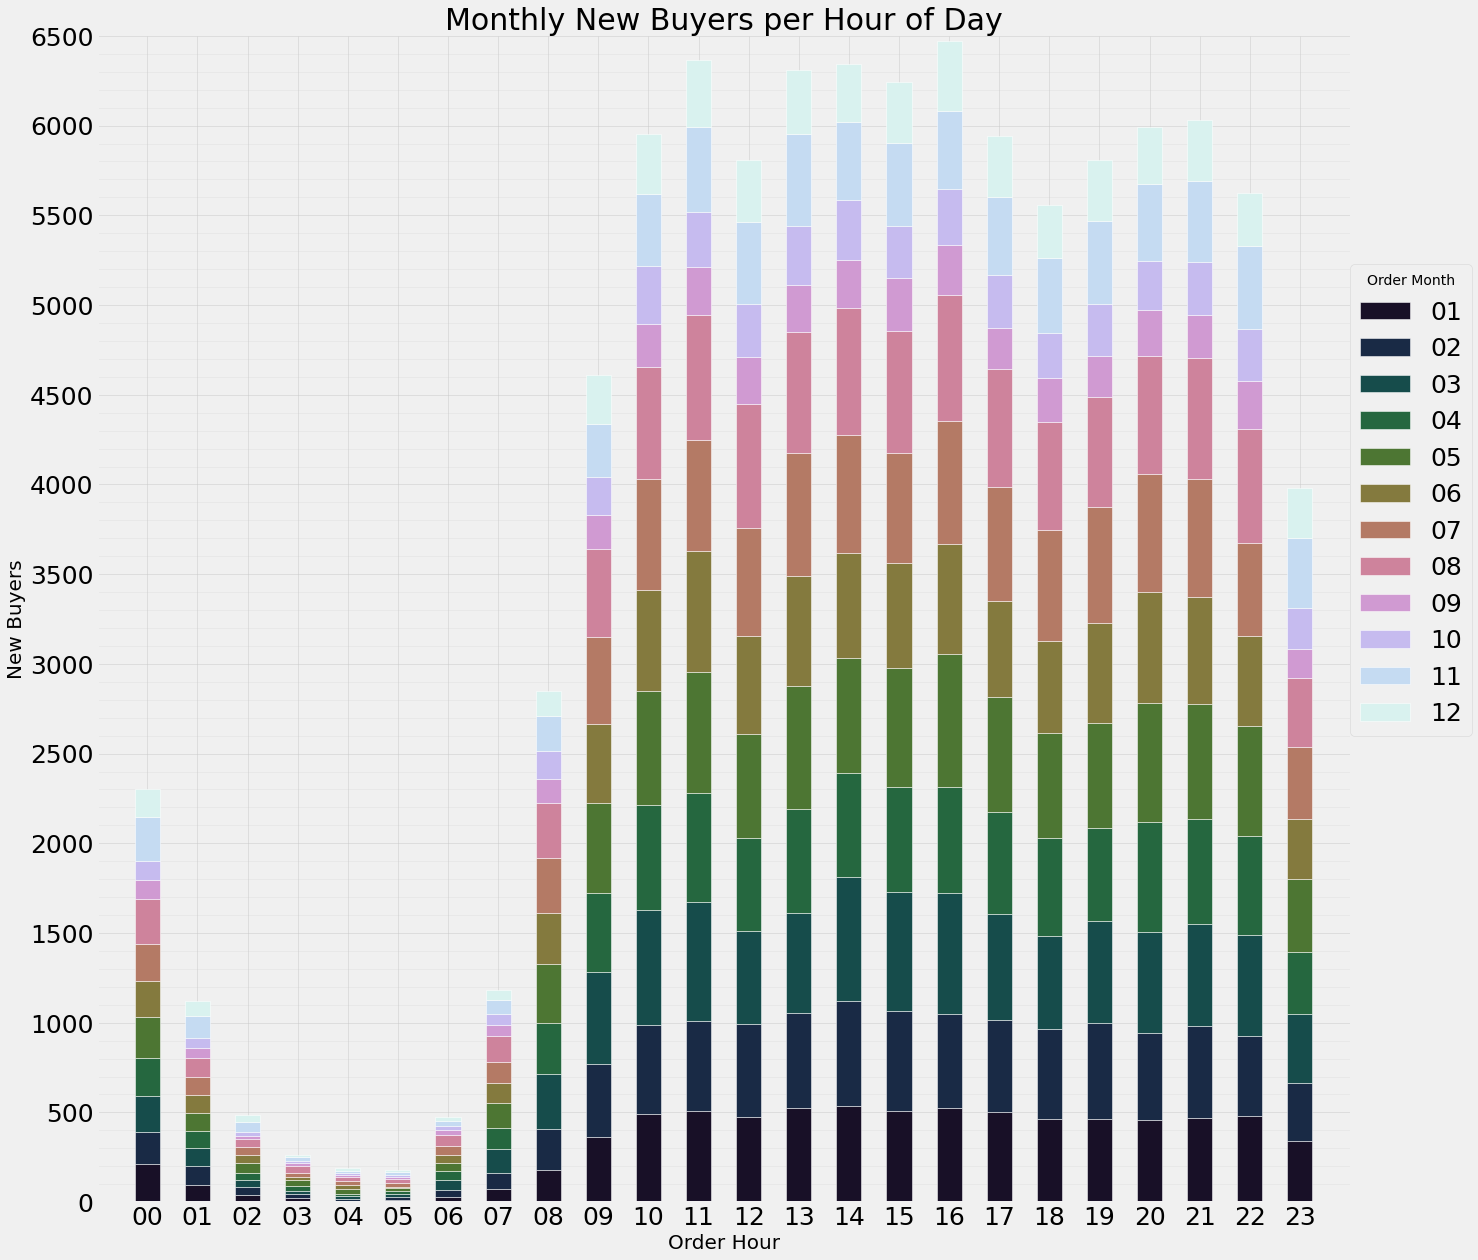

In [4]:
# Stacked Bar Chart
query = conn.execute("""
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT strftime('%m', order_purchase_timestamp)  as order_month,
    strftime('%H', order_purchase_timestamp)  as order_hour,
    COUNT(DISTINCT customer_unique_id) as new_buyers
FROM order_rank 
WHERE customer_order_rank = 1
GROUP BY 1,2
ORDER BY 1,2 
;
""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)


colors = sns.color_palette("cubehelix", n_colors=len('order_month'))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)

ax=results.pivot_table(index='order_hour',columns='order_month',values='new_buyers').plot(kind='bar',stacked=True,figsize=(20,20),fontsize=25,colormap=cmap1,edgecolor='white')
ax.legend(fontsize=25)

#set ylim
plt.ylim(-1, 6500)
plt.xlim(-1,24)

# grid
major_ticks = np.arange(0, 6501, 500)
minor_ticks = np.arange(0, 6501, 100)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')


# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# set y=0
ax.axhline(0, color='black', lw=1)
#change size of legend
ax.legend(fontsize=25,loc=(1.0,0.4), title='Order Month')
#hiding upper and right axis layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#changing the thickness
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#setlabels
ax.set_title('Monthly New Buyers per Hour of Day',fontsize=30,color='black')
ax.set_xlabel('Order Hour',fontsize=20,color='black')
ax.set_ylabel('New Buyers',fontsize=20,color='black')
#rotation
plt.xticks(rotation=360)
plt.savefig('monthly_new_buyers_per_hour.png', dpi=200, bbox_inches='tight')





In [3]:
# New buyers by first category they purchased
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as customer_order_rank
        FROM orders o
        INNER JOIN customers c 
        ON o.customer_id = c.customer_id
)
SELECT t.product_category_name_english as category_name,
    COUNT(DISTINCT o.customer_unique_id) as new_buyers
FROM order_rank o
INNER JOIN order_items oi 
ON o.order_id = oi.order_id
INNER JOIN products p 
ON oi.product_id = p.product_id
INNER JOIN product_translations t
ON p.product_category_name = t.product_category_name
WHERE o.customer_order_rank = 1
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,category_name,new_buyers
0,bed_bath_table,8946
1,health_beauty,8559
2,sports_leisure,7389
3,computers_accessories,6474
4,furniture_decor,6130
5,housewares,5694
6,watches_gifts,5477
7,telephony,4106
8,auto,3802
9,toys,3783


In [ ]:
# Plotted Bar Chart
c = conn.cursor()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

c.execute("""
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as customer_order_rank
    FROM orders o
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
)
SELECT t.product_category_name_english as category_name,
    COUNT(DISTINCT o.customer_unique_id) as new_buyers
FROM order_rank o
INNER JOIN order_items oi 
ON o.order_id = oi.order_id
INNER JOIN products p 
ON oi.product_id = p.product_id
INNER JOIN product_translations t
ON p.product_category_name = t.product_category_name
WHERE o.customer_order_rank = 1
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
;
""")
data = c.fetchall()

category_name = []
new_buyers = []

for row in data:
    category_name.append(row[0])
    new_buyers.append(row[1])
    
    ax.set(title = "Ten Most Common First Purchases (Category)",
       xlabel = "Category Name",
       ylabel = "New Buyers")

ax.bar(category_name,new_buyers)
plt.xticks(rotation=45)
plt.show()

In [8]:
# does the category new buyers purchase from change over time?
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as customer_order_rank
        FROM orders o
        INNER JOIN customers c 
        ON o.customer_id = c.customer_id
)
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as order_month,
    t.product_category_name_english as category_name,
    COUNT(DISTINCT o.customer_unique_id) as new_buyers
FROM order_rank o
INNER JOIN order_items oi 
ON o.order_id = oi.order_id
INNER JOIN products p 
ON oi.product_id = p.product_id
INNER JOIN product_translations t
ON p.product_category_name = t.product_category_name
WHERE o.customer_order_rank = 1
GROUP BY 1,2
ORDER BY 3 DESC
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,order_month,category_name,new_buyers
0,2018-06,health_beauty,779
1,2017-11,bed_bath_table,775
2,2018-08,health_beauty,763
3,2018-02,computers_accessories,758
4,2018-07,health_beauty,695
...,...,...,...
95,2018-02,electronics,296
96,2018-02,auto,295
97,2018-05,auto,292
98,2017-08,computers_accessories,290


In [ ]:
# new buyers by city
query = """
WITH order_rank AS (
    SELECT o.*,
        c.customer_city,
        c.customer_state,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as customer_order_rank
        FROM orders o
        INNER JOIN customers c 
        ON o.customer_id = c.customer_id
)
SELECT o.customer_city,
    o.customer_state,
    COUNT(DISTINCT o.customer_unique_id) as new_buyers
FROM order_rank o
INNER JOIN order_items oi 
ON o.order_id = oi.order_id
INNER JOIN products p 
ON oi.product_id = p.product_id
INNER JOIN product_translations t
ON p.product_category_name = t.product_category_name
WHERE o.customer_order_rank = 1
GROUP BY 1,2
ORDER BY 3 DESC
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [14]:
# LTV: Find the 30 day LTV 

query = """
WITH purchase_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), spend_per_customer_30d AS (
    SELECT por.customer_unique_id,
        CAST(SUM(op.payment_value) AS int) as spend_first_30d
    FROM purchase_order_rank por
    LEFT JOIN customers c
    ON por.customer_unique_id = c.customer_unique_id
    LEFT JOIN orders o
    ON por.customer_id = o.customer_id
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    AND o.order_purchase_timestamp - por.order_purchase_timestamp <= 30
    WHERE por.order_rank = 1
    GROUP BY 1
)
SELECT CAST(AVG(spend_first_30d) AS int) as avg_ltv
FROM spend_per_customer_30d
LIMIT 20
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,avg_ltv
0,166


In [16]:
# LTV: monthly 
query = """
WITH purchase_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), spend_per_customer_30d AS (
    SELECT por.customer_unique_id,
        strftime('%Y-%m', por.order_purchase_timestamp) as first_purchase_month,
        CAST(SUM(op.payment_value) AS int) as spend_first_30d
    FROM purchase_order_rank por
    LEFT JOIN customers c
    ON por.customer_unique_id = c.customer_unique_id
    LEFT JOIN orders o
    ON por.customer_id = o.customer_id
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    AND o.order_purchase_timestamp - por.order_purchase_timestamp <= 30
    WHERE por.order_rank = 1
    GROUP BY 1,2
)
SELECT first_purchase_month,
    COUNT(DISTINCT customer_unique_id) as total_buyers,
    CAST(AVG(spend_first_30d) AS int) as avg_ltv
FROM spend_per_customer_30d
GROUP BY 1
ORDER BY 1 
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,first_purchase_month,total_buyers,avg_ltv
0,2016-09,4,83
1,2016-10,316,184
2,2016-12,1,39
3,2017-01,749,185
4,2017-02,1719,167
5,2017-03,2584,172
6,2017-04,2316,179
7,2017-05,3544,166
8,2017-06,3099,163
9,2017-07,3862,152


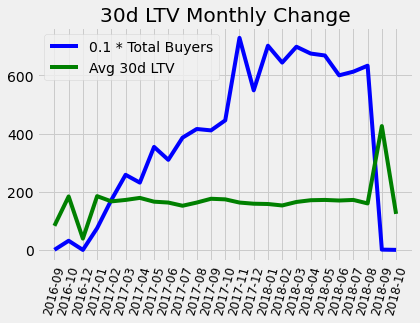

In [15]:
# Plot
c = conn.cursor()
fig, ax = plt.subplots()

c.execute("""
WITH purchase_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
    FROM orders o
    INNER JOIN customers c
    ON o.customer_id = c.customer_id
), spend_per_customer_30d AS (
    SELECT por.customer_unique_id,
        strftime('%Y-%m', por.order_purchase_timestamp) as first_purchase_month,
        CAST(SUM(op.payment_value) AS int) as spend_first_30d
    FROM purchase_order_rank por
    LEFT JOIN customers c
    ON por.customer_unique_id = c.customer_unique_id
    LEFT JOIN orders o
    ON por.customer_id = o.customer_id
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    AND o.order_purchase_timestamp - por.order_purchase_timestamp <= 30
    WHERE por.order_rank = 1
    GROUP BY 1,2
)
SELECT first_purchase_month,
    .1 * COUNT(DISTINCT customer_unique_id) as total_buyers,
    CAST(AVG(spend_first_30d) AS int) as avg_ltv
FROM spend_per_customer_30d
GROUP BY 1
ORDER BY 1 
;
""")
data = c.fetchall()

first_purchase_month = []
total_buyers = []
avg_ltv = []
width = 0.4

for row in data:
    first_purchase_month.append(row[0])
    total_buyers.append(row[1])
    avg_ltv.append(row[2])
    
    ax.set(title = "30d LTV Monthly Change")
    
plt.plot(first_purchase_month, total_buyers, "-b", label="0.1 * Total Buyers")
plt.plot(first_purchase_month, avg_ltv, "-g", label = "Avg 30d LTV")
plt.legend()
plt.xticks(rotation=75, size=12)
plt.show()

In [ ]:
# 14 day repurchase rate for new buyers

In [3]:
# what percent of first purchases had a four star review or above?

query = """
WITH customer_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
        FROM orders o
        INNER JOIN customers c
        ON o.customer_id = c.customer_id
), good_reviews AS (
    SELECT c.*
    FROM customer_order_rank c
    INNER JOIN order_reviews r
    ON c.order_id = r.order_id
    WHERE r.review_score >= 4
)
SELECT 1.0 * COUNT(DISTINCT gr.customer_unique_id) 
    / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) as pcnt_w_good_rview
FROM customer_order_rank c
LEFT JOIN good_reviews gr
ON c.order_id = gr.order_id
WHERE c.order_rank = 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,pcnt_w_good_rview
0,0.766681


In [4]:
# what percent of first purchases had a five star review or above?

query = """
WITH customer_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
        FROM orders o
        INNER JOIN customers c
        ON o.customer_id = c.customer_id
), good_reviews AS (
    SELECT c.*
    FROM customer_order_rank c
    INNER JOIN order_reviews r
    ON c.order_id = r.order_id
    WHERE r.review_score >= 5
)
SELECT 1.0 * COUNT(DISTINCT gr.customer_unique_id) 
    / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) as pcnt_w_good_rview
FROM customer_order_rank c
LEFT JOIN good_reviews gr
ON c.order_id = gr.order_id
WHERE c.order_rank = 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,pcnt_w_good_rview
0,0.573728


In [5]:
# Engagement - are the buyers we acquire having good experiences? (eg reviews)
# Percent of newly acquired customers who leave a review 4 or higher 
# customers who leave review >= 4 / newly acquired customers

query = """
WITH customer_order_rank AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
        FROM orders o
        INNER JOIN customers c
        ON o.customer_id = c.customer_id
), good_reviews AS (
    SELECT c.*
    FROM customer_order_rank c
    INNER JOIN order_reviews r
    ON c.order_id = r.order_id
    WHERE r.review_score >= 4
)
SELECT 1.0 * COUNT(DISTINCT gr.customer_unique_id) 
    / NULLIF(COUNT(DISTINCT c.customer_unique_id),0) as pcnt_w_good_rview
FROM customer_order_rank c
LEFT JOIN good_reviews gr
ON c.order_id = gr.order_id
WHERE c.order_rank = 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,pcnt_w_good_rview
0,0.766681


In [6]:
# Avg purchases per active customer

query = """
WITH customer_calculations AS (
    SELECT DISTINCT c.customer_id,
        MAX(o.order_purchase_timestamp) as last_order_date,
        COUNT(o.order_id) as order_count,
        AVG(op.payment_value) as avg_spent
    FROM orders o 
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
    INNER JOIN order_payments op 
    ON o.order_id = op.order_id
    GROUP BY 1
), quantiles AS (
    SELECT customer_id,
        NTILE(4) OVER (ORDER BY last_order_date) as rfm_recency,
        NTILE(4) OVER (ORDER BY order_count) as rfm_frequency,
        NTILE(4) OVER (ORDER BY avg_spent) as rfm_monetary
    FROM customer_calculations
), combined_rfm AS (
SELECT customer_id, 
    rfm_recency * 100 + rfm_frequency * 10 + rfm_monetary as rfm_combined
FROM quantiles
), total_orders_per_active_cust AS (
    SELECT DISTINCT o.customer_id,
        COUNT(DISTINCT o.order_id) as total_orders
    FROM orders o 
    INNER JOIN combined_rfm c
    ON o.customer_id = c.customer_id
    WHERE c.rfm_combined > 400
    GROUP BY 1
    ORDER BY 2 DESC
)
SELECT AVG(total_orders) as avg_orders
FROM total_orders_per_active_cust
;
"""

df = pd.read_sql(query, conn)
df.head(100)



,avg_orders
0,1.0


In [7]:
# Avg $ spent per active customer

query = """
WITH customer_calculations AS (
    SELECT DISTINCT c.customer_id,
        MAX(o.order_purchase_timestamp) as last_order_date,
        COUNT(o.order_id) as order_count,
        AVG(op.payment_value) as avg_spent
    FROM orders o 
    INNER JOIN customers c 
    ON o.customer_id = c.customer_id
    INNER JOIN order_payments op 
    ON o.order_id = op.order_id
    GROUP BY 1
), quantiles AS (
    SELECT customer_id,
        NTILE(4) OVER (ORDER BY last_order_date) as rfm_recency,
        NTILE(4) OVER (ORDER BY order_count) as rfm_frequency,
        NTILE(4) OVER (ORDER BY avg_spent) as rfm_monetary
    FROM customer_calculations
), combined_rfm AS (
SELECT customer_id, 
    rfm_recency * 100 + rfm_frequency * 10 + rfm_monetary as rfm_combined
FROM quantiles
), total_spent_per_active_cust AS (
    SELECT DISTINCT o.customer_id,
        SUM(op.payment_value) as total_spent
    FROM orders o
    LEFT JOIN order_payments op
    ON o.order_id = op.order_id
    INNER JOIN combined_rfm c
    ON o.customer_id = c.customer_id
    WHERE c.rfm_combined > 400
    GROUP BY 1
    ORDER BY 2 DESC
)
SELECT AVG(total_spent) as avg_spent_per_active_cust
FROM total_spent_per_active_cust
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,avg_spent_per_active_cust
0,165.532563


In [18]:
# Avg star rating

query = """
SELECT AVG(review_score) as avg_star_rating
FROM order_reviews 
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,avg_star_rating
0,4.07089


In [23]:
# Avg star rating by month

query = """
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month, 
    COUNT(DISTINCT r.review_id) as total_reviews,
    AVG(r.review_score) as avg_star_rating
FROM order_reviews r
INNER JOIN orders o 
ON r.order_id = o.order_id
GROUP BY 1
ORDER BY 1  
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,month,total_reviews,avg_star_rating
0,2016-09,4,1.000000
1,2016-10,324,3.529052
2,2016-12,1,5.000000
3,2017-01,788,4.054523
4,2017-02,1773,4.005034
5,2017-03,2672,4.055988
6,2017-04,2393,4.031937
7,2017-05,3688,4.123896
8,2017-06,3232,4.129997
9,2017-07,4011,4.157325


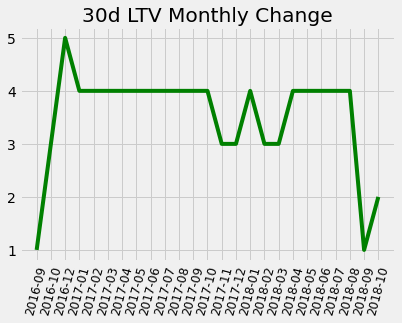

In [11]:
# Plot
c = conn.cursor()
fig, ax = plt.subplots()

c.execute("""
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month,
    1.0 * CAST(AVG(r.review_score) AS int) as avg_star_rating
FROM order_reviews r
INNER JOIN orders o 
ON r.order_id = o.order_id
GROUP BY 1
ORDER BY 1  
;
""")
data = c.fetchall()

month = []
avg_star_rating = []
width = 0.4

for row in data:
    month.append(row[0])
    avg_star_rating.append(row[1])
    
    ax.set(title = "30d LTV Monthly Change")
    
plt.plot(month, avg_star_rating, "-g", label = "Avg 30d LTV")
plt.xticks(rotation=75, size=12)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

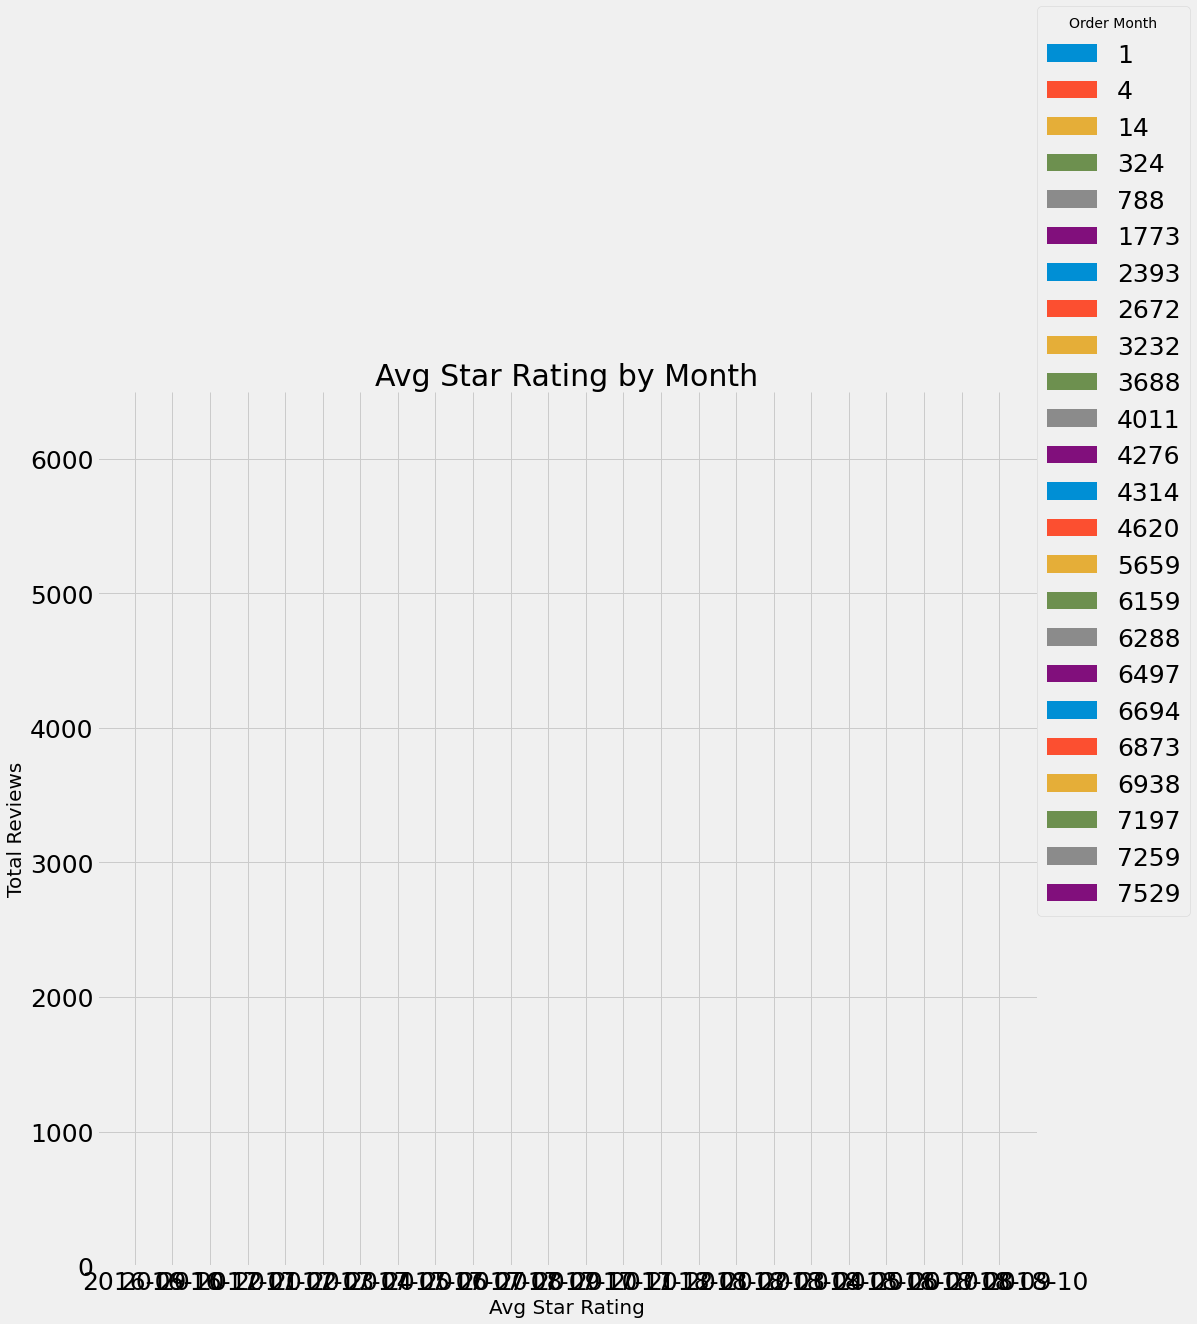

In [12]:
# Stacked Bar Chart
query = conn.execute("""
SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month, 
    COUNT(DISTINCT r.review_id) as total_reviews,
    AVG(r.review_score) as avg_star_rating
FROM order_reviews r
INNER JOIN orders o 
ON r.order_id = o.order_id
GROUP BY 1
ORDER BY 3 DESC 
;
""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

ax=results.pivot_table(index='month',columns='total_reviews',values='avg_star_rating').plot(kind='bar',stacked=True,figsize=(15,15),fontsize=25)
ax.legend(fontsize=25)

#set ylim
plt.ylim(-1, 6500)
plt.xlim(-1,24)
#grid on
plt.grid(2)
# set y=0
ax.axhline(0, color='black', lw=1)
#change size of legend
ax.legend(fontsize=25,loc=(1.0,0.4), title='Order Month')
#hiding upper and right axis layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#changing the thickness
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#setlabels
ax.set_title('Avg Star Rating by Month',fontsize=30,color='black')
ax.set_xlabel('Avg Star Rating',fontsize=20,color='black')
ax.set_ylabel('Total Reviews',fontsize=20,color='black')
#rotation
plt.xticks(rotation=360)


In [ ]:
# review rate 

In [13]:
# distribution of reviews
# easy bar chart

query = """
SELECT review_score,
    COUNT(DISTINCT review_id) total_reviews
FROM order_reviews
GROUP BY 1
ORDER BY 1
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,review_score,total_reviews
0,1,11712
1,2,3196
2,3,8203
3,4,19062
4,5,57000


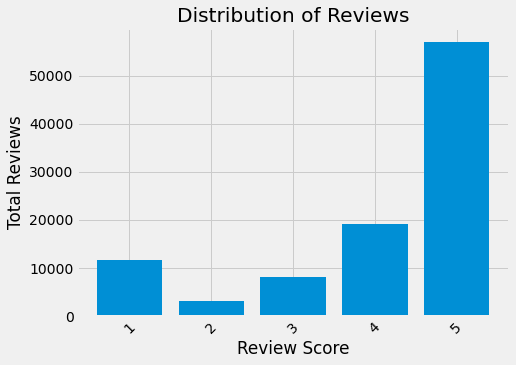

In [2]:
# Plotted Bar Chart
c = conn.cursor()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

c.execute("""
SELECT review_score,
    COUNT(DISTINCT review_id) total_reviews
FROM order_reviews
GROUP BY 1
ORDER BY 1
;
""")
data = c.fetchall()

review_score = []
total_reviews = []

for row in data:
    review_score.append(row[0])
    total_reviews.append(row[1])
    
    ax.set(title = "Distribution of Reviews",
       xlabel = "Review Score",
       ylabel = "Total Reviews")

ax.bar(review_score,total_reviews)
plt.xticks(rotation=45)
plt.show()

In [3]:
# distribution of reviews over time
# stacked bar chart

query = """
SELECT strftime('%Y-%m', review_creation_date) as review_month,
    review_score,
    COUNT(DISTINCT review_id) total_reviews
FROM order_reviews
GROUP BY 1,2
ORDER BY 1,2
;
"""

df = pd.read_sql(query, conn)
df.head(100)

,review_month,review_score,total_reviews
0,2016-10,1,26
1,2016-10,2,4
2,2016-10,3,14
3,2016-10,4,30
4,2016-10,5,104
...,...,...,...
95,2018-05,2,213
96,2018-05,3,570
97,2018-05,4,1481
98,2018-05,5,4508


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

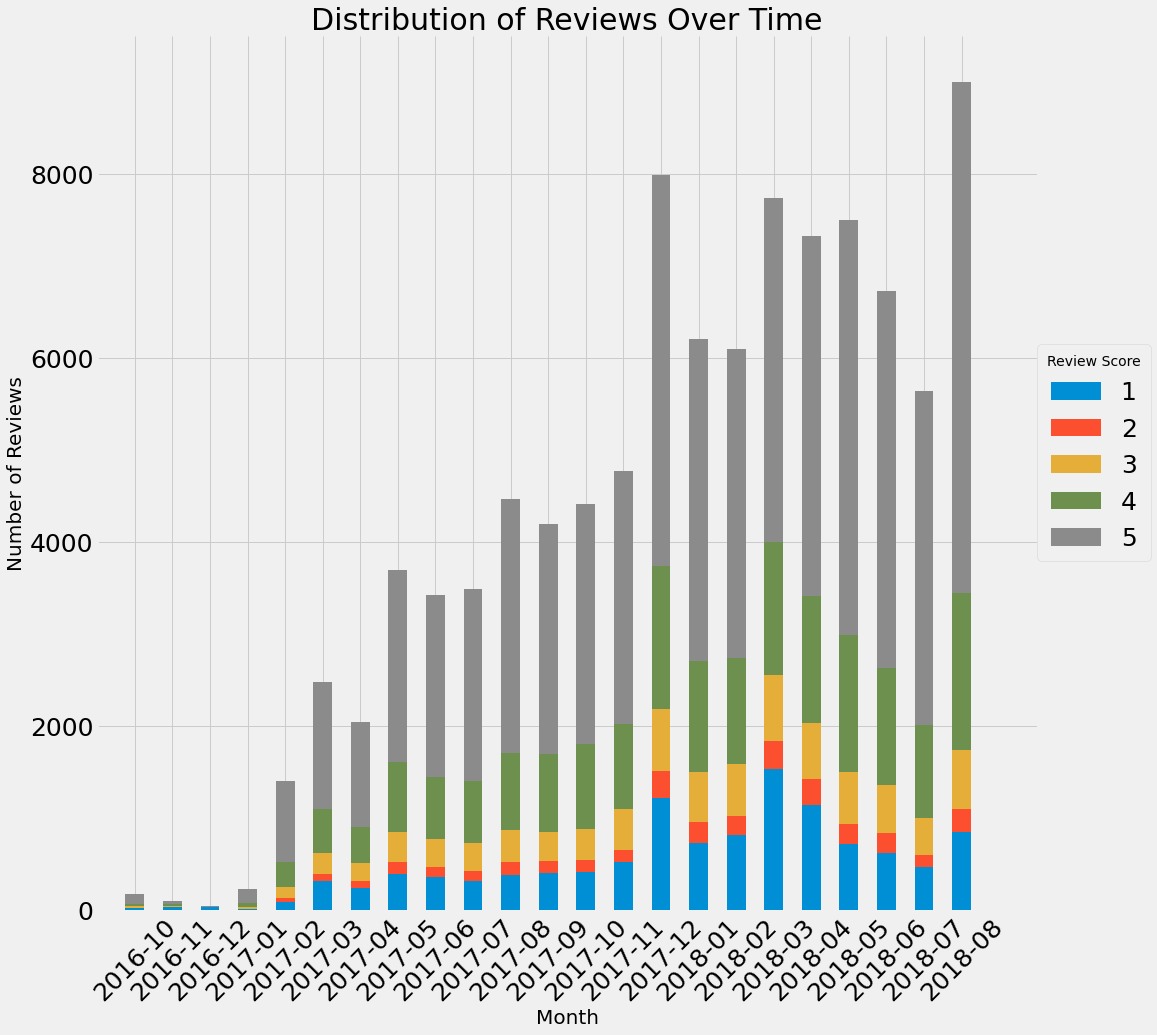

In [32]:
# Stacked Bar Chart
query = conn.execute("""
SELECT strftime('%Y-%m', review_creation_date) as review_month,
    review_score,
    COUNT(DISTINCT review_id) total_reviews
FROM order_reviews
GROUP BY 1,2
ORDER BY 1,2
;
""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

ax=results.pivot_table(index='review_month',columns='review_score', values='total_reviews').plot(kind='bar',stacked=True,figsize=(15,15),fontsize=25)
ax.legend(fontsize=25)

#set ylim
plt.ylim(-1, 9500)
plt.xlim(-1,24)
#grid on
plt.grid(2)
# set y=0
ax.axhline(0, color='black', lw=1)
#change size of legend
ax.legend(fontsize=25,loc=(1.0,0.4), title='Review Score')
#hiding upper and right axis layout
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#changing the thickness
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#setlabels
ax.set_title('Distribution of Reviews Over Time',fontsize=30,color='black')
ax.set_xlabel('Month',fontsize=20,color='black')
ax.set_ylabel('Number of Reviews',fontsize=20,color='black')
#rotation
plt.xticks(rotation=45)

In [ ]:
# Avg star rating per product category
# group by month

query = """
SELECT t.product_category_name_english,
    COUNT(*) as total_reviews,
    AVG(r.review_score) as avg_star_rating
FROM order_reviews r
INNER JOIN order_items oi
ON r.order_id = oi.order_id
INNER JOIN products p 
ON oi.product_id = p.product_id 
INNER JOIN product_translations t 
ON p.product_category_name = t.product_category_name
GROUP BY 1
ORDER BY 2 DESC
;
"""

df = pd.read_sql(query, conn)
df.head(100)

In [31]:
# What percent of new buyers are still transacting on the platform 3+ months after first purchase?
query = """
WITH order_details AS (
    SELECT o.*,
        c.customer_unique_id,
        RANK() OVER(PARTITION BY c.customer_unique_id ORDER BY o.order_id) as order_rank
        FROM orders o
        INNER JOIN customers c
        ON o.customer_id = c.customer_id
), new_buyers AS (
    SELECT *
    FROM order_details
    WHERE order_rank = 1
)
SELECT CAST(COUNT(b.customer_unique_id) / NULLIF(COUNT(a.customer_unique_id),0) AS float) as pcnt_still_transacting
FROM new_buyers a
LEFT JOIN new_buyers b 
ON a.customer_unique_id = b.customer_unique_id
AND b.order_purchase_timestamp > a.order_purchase_timestamp
AND b.order_purchase_timestamp - a.order_purchase_timestamp <= 90"""

df = pd.read_sql(query, conn)
df.head(100)

,pcnt_still_transacting
0,0.0


In [ ]:
# What is the 14-day repurchase rate for customers with negative reviews (3 or below)?

In [ ]:
# What is the average star rating for reviews by month? Is it trending up or down?

In [ ]:
# What is the average review rate (% of orders that have a review)? How has this changed over time?